In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as patches
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
path = "/content/drive/MyDrive/SportsData/Sample_Game_1_RawTrackingData_Away_Team.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cd /content/drive/MyDrive/SportsData/Football-LLM
!git config --global user.email 'csm010311@naver.com'
!git config --global user.name 'Csenongmin'
!git add Test_code.ipynb

In [ ]:
df = pd.read_csv(path,skiprows=2)
df = df.iloc[:, :-8]

temp = ""
for column in df.columns:
    newColumn = ""
    if "Player" in column:
        temp = column[-2:]
        newColumn = column + "X"
    elif "Unnamed" in column:
        newColumn = "Player" + temp + "Y"
    else:
        continue
    df.rename(columns={column: newColumn}, inplace=True)

# period가 1인 데이터 분리
df_period1 = df[df['Period'] == 1]

# period가 2인 데이터 분리
df_period2 = df[df['Period'] == 2]
# 모든 Player의 X, Y 좌표를 분리하여 새로운 DataFrame 생성
player_positions = []
for col in df_period1.columns:
    if 'X' in col:  # X 좌표
        player_id = col.replace('X', '')  # Player ID 추출
        player_positions.append(
            pd.DataFrame({
                'Player': player_id,
                'X': df_period1[col],
                'Y': df_period1[f'{player_id}Y']
            })
        )

player_df = pd.concat(player_positions, ignore_index=True)


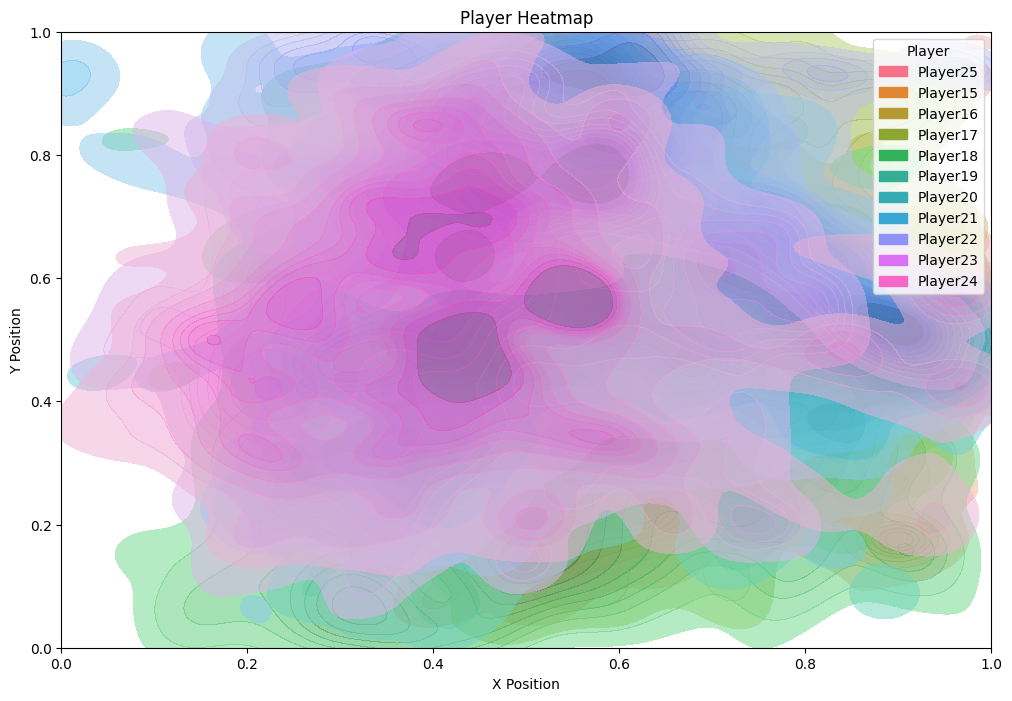

In [ ]:
# 히트맵 생성
plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=player_df,
    x='X',
    y='Y',
    hue='Player',  # 선수별 색상 분리
    fill=True,
    alpha=0.5,
    common_norm=False,
    #bw_adjust=0.5  # 더 세밀하게 커널 밀도 계산
)
plt.title("Player Heatmap")
plt.xlim(0, 1)  # x 좌표 범위 (정규화된 값 기준)
plt.ylim(0, 1)  # y 좌표 범위
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

STR 그리드, quadtree

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

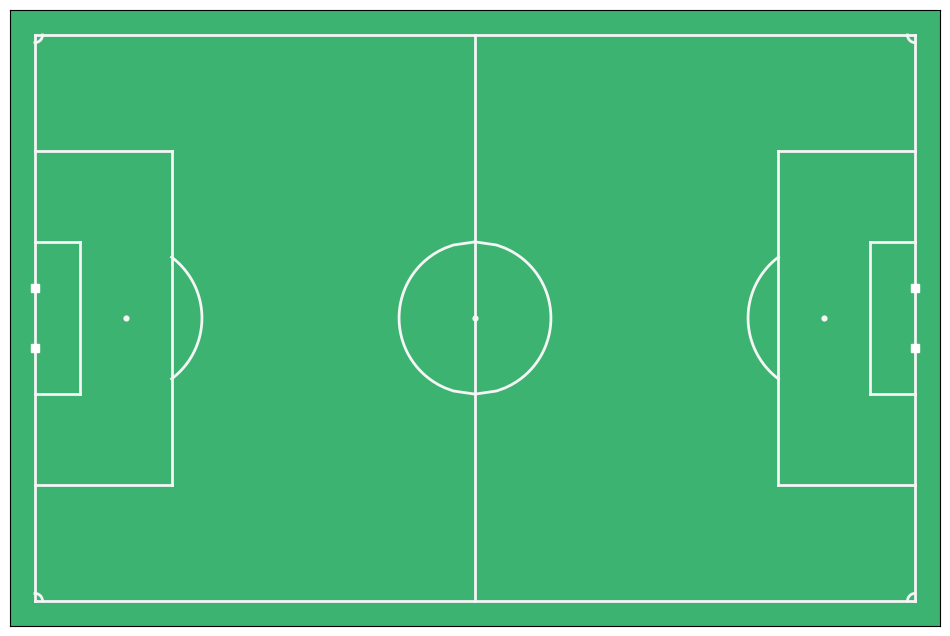

In [ ]:
def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    """ plot_pitch

    Plots a soccer pitch. All distance units converted to meters.

    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20

    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1]
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)

    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

plot_pitch()

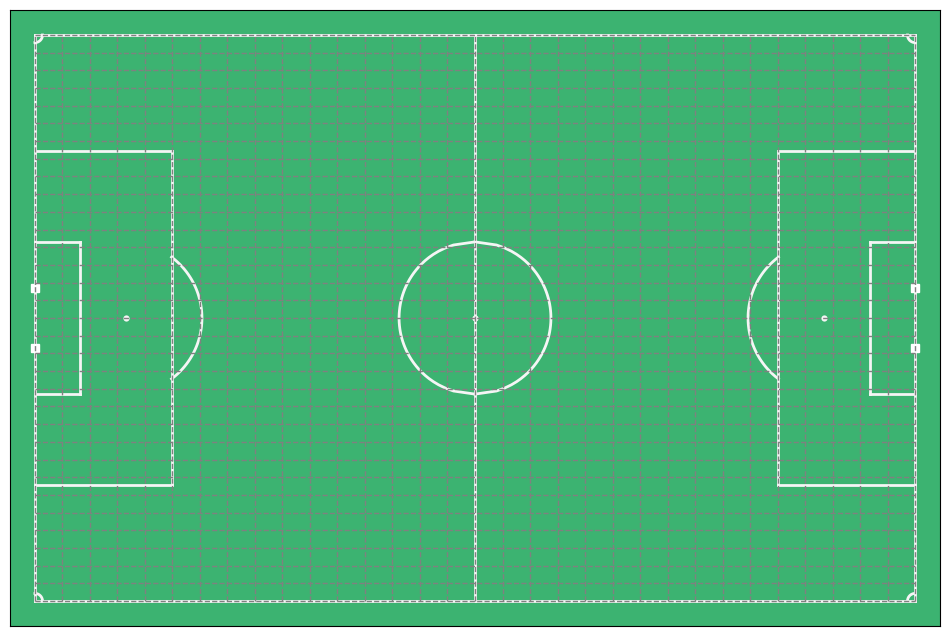

In [ ]:
def plot_pitch_with_grid(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """
    Plots a soccer pitch with an optional grid overlay. Divides the pitch into 64 equal sections.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plot_pitch(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기 가져오기
    pitch_length, pitch_width = field_dimen

    # 축구장을 32 x 32로 나누기 위한 선 그리기
    num_divisions = 32
    x_divisions = np.linspace(-pitch_length / 2, pitch_length / 2, num_divisions + 1)
    y_divisions = np.linspace(-pitch_width / 2, pitch_width / 2, num_divisions + 1)

    # 격자 선 그리기
    for x in x_divisions:
        ax.plot([x, x], [-pitch_width / 2, pitch_width / 2], 'gray', linestyle='--', linewidth=1)

    for y in y_divisions:
        ax.plot([-pitch_length / 2, pitch_length / 2], [y, y], 'gray', linestyle='--', linewidth=1)

    return fig, ax

# 축구장과 격자를 그리기
plot_pitch_with_grid()
plt.show()

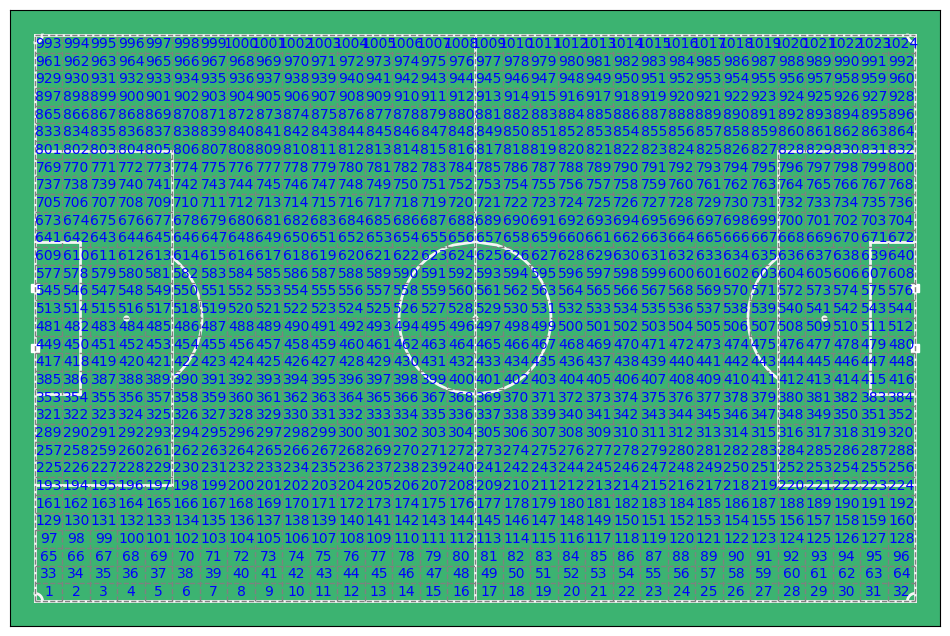

In [ ]:
def plot_pitch_with_numbers(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    fig, ax = plot_pitch_with_grid(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # 번호를 격자 중심에 표시
    number = 1
    for i in range(num_divisions):
        for j in range(num_divisions):
            x = -pitch_length / 2 + (j + 0.5) * cell_length
            y = -pitch_width / 2 + (i + 0.5) * cell_width
            ax.text(x, y, str(number), color='blue', fontsize=10, ha='center', va='center')
            number += 1

    return fig, ax

# Plot pitch with sequential numbering
plot_pitch_with_numbers()
plt.show()

In [ ]:
import numpy as np
from hilbert import decode, encode

# Turn an ndarray of Hilber integers into locations.
# 2 is the number of dimensions, 3 is the number of bits per dimension
arr = np.arange(16) #32*32
locs = decode(arr, 2, 2)

print(locs)
# prints [[0 1]
#         [1 1]
#         [1 0]]

# You can go the other way also, of course.
H = encode(locs, 2, 2)

print(H)
for i,point in enumerate(locs):
    print(f"Point {i}: {point}")
# prints array([1, 2, 3], dtype=uint64)

[[0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 2]
 [0 3]
 [1 3]
 [1 2]
 [2 2]
 [2 3]
 [3 3]
 [3 2]
 [3 1]
 [2 1]
 [2 0]
 [3 0]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Point 0: [0 0]
Point 1: [1 0]
Point 2: [1 1]
Point 3: [0 1]
Point 4: [0 2]
Point 5: [0 3]
Point 6: [1 3]
Point 7: [1 2]
Point 8: [2 2]
Point 9: [2 3]
Point 10: [3 3]
Point 11: [3 2]
Point 12: [3 1]
Point 13: [2 1]
Point 14: [2 0]
Point 15: [3 0]


## 힐버트 곡선

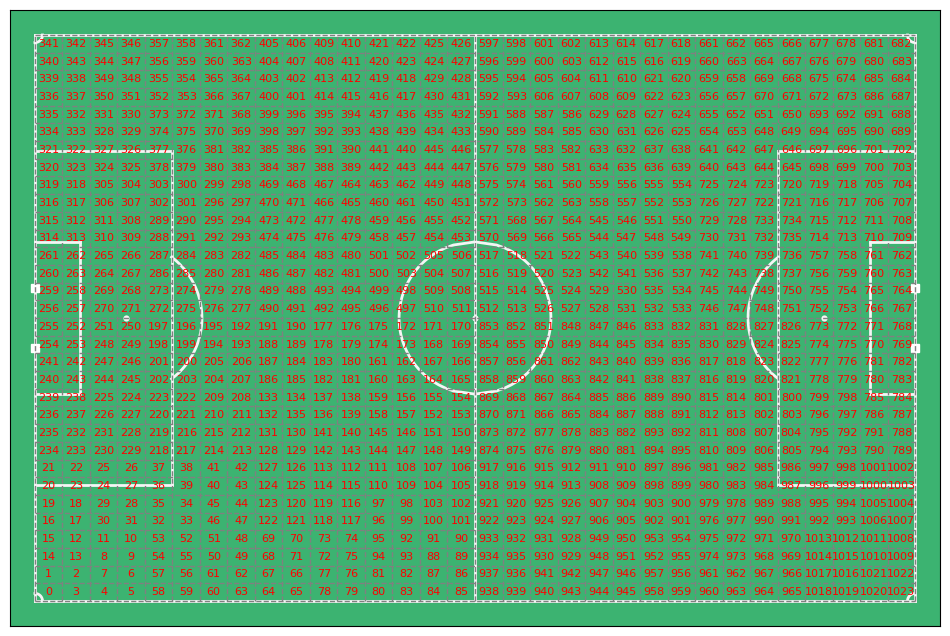

In [ ]:
def plot_pitch_with_hilbert_labels(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """Plots a soccer pitch and overlays Hilbert Curve-based numbering on it."""
    fig, ax = plot_pitch_with_grid(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Hilbert Curve 좌표 생성
    arr = np.arange(1024) #32*32
    locs = decode(arr, 2, 5)

    for i, point in enumerate(locs):
      x, y = point
      x_coord = -pitch_length / 2 + (x + 0.5) * cell_length
      y_coord = -pitch_width / 2 + (y + 0.5) * cell_width
      ax.text(x_coord, y_coord, i, color='red', fontsize=8, ha='center', va='center')

    return fig, ax

# Plot pitch with Hilbert Curve numbering
plot_pitch_with_hilbert_labels()
plt.show()



## z-order



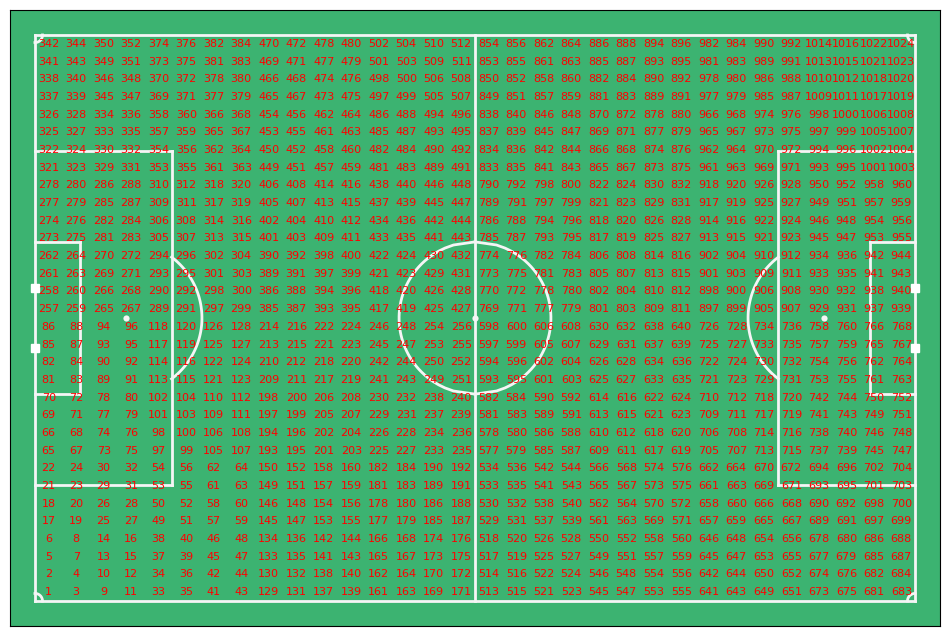

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def z_order(x, y, n):
    """
    Generate Z-order (Morton order) for a 2D grid of size 2^n x 2^n.
    """
    z = 0
    for i in range(n):
        z |= (x & 1) << (2 * i + 1)  # x의 비트를 interleave
        z |= (y & 1) << (2 * i)      # y의 비트를 interleave
        x >>= 1  # x를 오른쪽으로 쉬프트
        y >>= 1  # y를 오른쪽으로 쉬프트
    return z

def plot_pitch_with_z_order(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """Plots a soccer pitch and overlays Z-order-based numbering on it."""
    fig, ax = plot_pitch(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Z-order 좌표 생성
    n = 5 # 2^5= 32*32격자
    num_points = 2 ** (2 * n)
    z_order_coords = [(x, y) for x in range(2 ** n) for y in range(2 ** n)]
    z_order_indices = [z_order(x, y, n) for x, y in z_order_coords]

    # Z-order 순서대로 번호를 표시
    for i, (z_idx, (x, y)) in enumerate(sorted(zip(z_order_indices, z_order_coords))):
        # Normalize Z-order coordinates to match pitch dimensions
        x_coord = -pitch_length / 2 + (x + 0.5) * cell_length
        y_coord = -pitch_width / 2 + (y + 0.5) * cell_width

        # 번호를 격자 중심에 표시
        ax.text(x_coord, y_coord, str(i + 1), color='red', fontsize=8, ha='center', va='center')

    return fig, ax

# Plot pitch with Z-order numbering
plot_pitch_with_z_order()
plt.show()


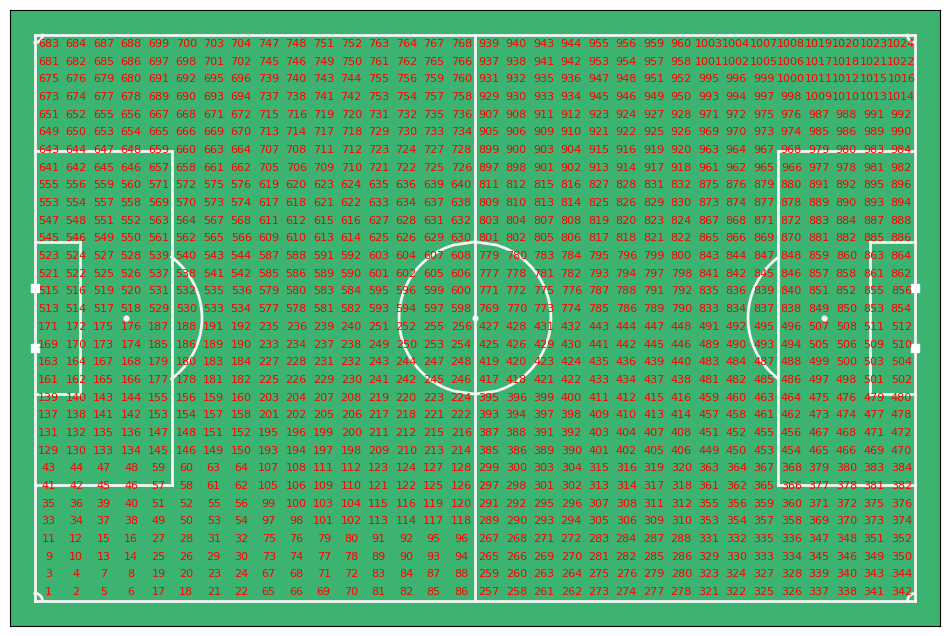

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def z_order(x, y, n):
    """
    Generate Z-order (Morton order) with a preference for x-coordinate.
    This version prioritizes x over y for numbering.
    """
    z = 0
    for i in range(n):
        # 먼저 x의 비트를 interleave, y는 뒤에 결합
        z |= (x & 1) << (2 * i)   # x의 비트를 interleave
        z |= (y & 1) << (2 * i + 1)  # y의 비트를 interleave
        x >>= 1  # x를 오른쪽으로 쉬프트
        y >>= 1  # y를 오른쪽으로 쉬프트
    return z

def plot_pitch_with_z_order(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """Plots a soccer pitch and overlays Z-order-based numbering on it."""
    fig, ax = plot_pitch(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Z-order 좌표 생성
    n = 5  # 2^5 = 32x32 격자
    z_order_coords = [(x, y) for x in range(2 ** n) for y in range(2 ** n)]
    z_order_indices = [z_order(x, y, n) for x, y in z_order_coords]

    # Z-order 순서대로 번호를 표시
    for i, (z_idx, (x, y)) in enumerate(sorted(zip(z_order_indices, z_order_coords))):
        # Normalize Z-order coordinates to match pitch dimensions
        x_coord = -pitch_length / 2 + (x + 0.5) * cell_length
        y_coord = -pitch_width / 2 + (y + 0.5) * cell_width

        # 번호를 격자 중심에 표시
        ax.text(x_coord, y_coord, str(i + 1), color='red', fontsize=8, ha='center', va='center')

    return fig, ax

# Plot pitch with Z-order numbering
plot_pitch_with_z_order()
plt.show()
